In [1]:
import typing

import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

# General Setup

## Functions

In [2]:
def plot_all(list_of_x : typing.List):
  fig, axes = plt.subplots(len(list_of_x), 1)
  length = max(map(len, list_of_x)) - 1
  for i, x in enumerate(list_of_x):
    axes[i].plot(range(len(x)), x)
    # axes[i].set_xlim(0, length)
    # axes[i].set_ylim(ymin=0)


def convolve(x, filter):
  n = filter.size
  segments = [x[i:(i+n)] for i in range(x.size - n + 1)]
  return np.array([s.dot(filter) for s in segments])
  
  

In [3]:

def plot_multiple_histories(histories : typing.Dict, metric='loss', use_greyscale=True, show_validation=False, sort_agg_func=np.mean, sort_history_length=2, *args, **kwargs):
  """
  Plots the training history of multiple models on the same plot for comparison.
  
  Parameters:
    histories: List of History objects from multiple model's fit() calls.
    metric: The metric to plot ('loss', 'accuracy', etc.).
    labels: List of labels for the models. If None, defaults to 'Model 1', 'Model 2', etc.
  """
  # Check if labels are provided, otherwise generate default labels
  # if labels is None:
  #   labels = [f'Model {i+1}' for i in range(len(histories))]
  
  # Initialize the plot
  plt.figure(figsize=(10, 6))
  
  norm = plt.Normalize(vmin=0, vmax=len(histories))
  grayscale_cmap = plt.colormaps['gray']
  
  sorted_keys = sorted(histories.keys(), key=(lambda k: sort_agg_func(histories[k].history[metric][:-sort_history_length])))
  for i, label in enumerate(sorted_keys):
    history = histories[label]
    #for i, (label, history) in enumerate(histories.items()):
    epochs = range(1, len(history.history[metric]) + 1)
    
    # Plot training metric
    plt.plot(epochs, history.history[metric], label=f'{label} {metric.capitalize()}', color=grayscale_cmap(norm(i)))
    
    # Plot validation metric if available
    if show_validation and f'val_{metric}' in history.history:
      plt.plot(epochs, history.history[f'val_{metric}'], '--', label=f'{label} Validation {metric.capitalize()}', color=grayscale_cmap(norm(i)))
  
  # Add labels and title
  plt.title(f'Comparison of {metric.capitalize()} Between Models')
  plt.xlabel('Epochs')
  plt.ylabel(metric.capitalize())
  plt.legend()
  
  # Show plot
  plt.show()


# Introduction Examples

## Convolution

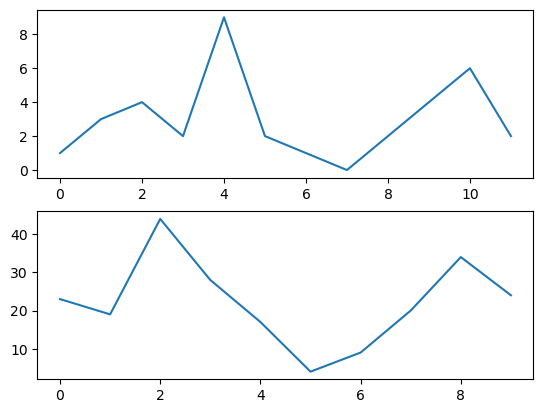

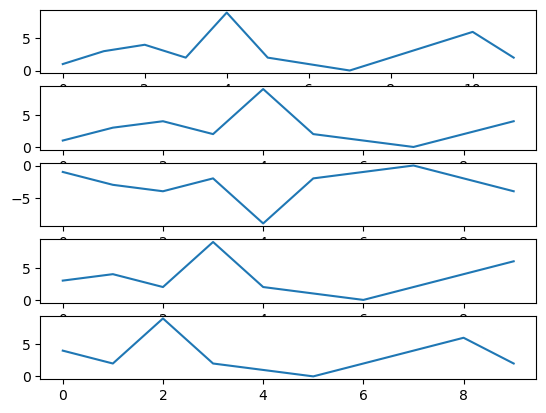

In [4]:
x = np.array([1, 3, 4, 2, 9, 2, 1, 0, 2, 4, 6, 2])

plot_all([
  x,
  convolve(x, np.array([1, 2, 4])),
])

plot_all([
  x,
  convolve(x, np.array([1, 0, 0])),
  convolve(x, np.array([-1, 0, 0])),
  convolve(x, np.array([0, 1, 0])),
  convolve(x, np.array([0, 0, 1])),
])




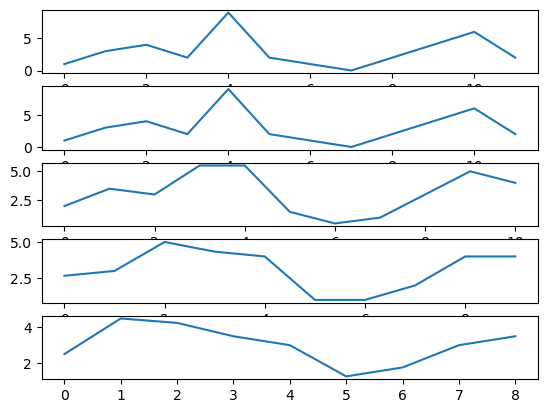

In [5]:

plot_all([
  x,
  convolve(x, np.full(1, 1)),
  convolve(x, np.full(2, 1.0/2)),
  convolve(x, np.full(3, 1.0/3)),
  convolve(x, np.full(4, 1.0/4)),
])


### Dirac

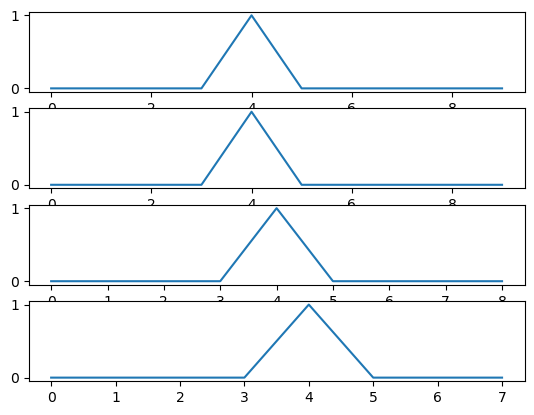

In [6]:
dirac = np.zeros(10)
dirac[4] = 1

plot_all([
  dirac,
  convolve(dirac, np.array([1])),
  convolve(dirac, np.array([1, 0])),
  convolve(dirac, np.array([1, 0, 0]))
])


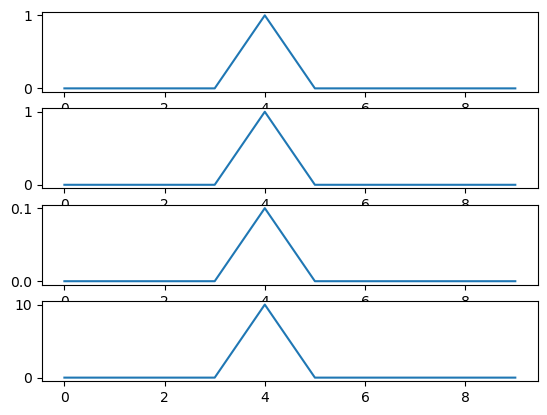

In [7]:

plot_all([
  dirac,
  convolve(dirac, np.array([1])),
  convolve(dirac, np.array([0.1])),
  convolve(dirac, np.array([10]))
])



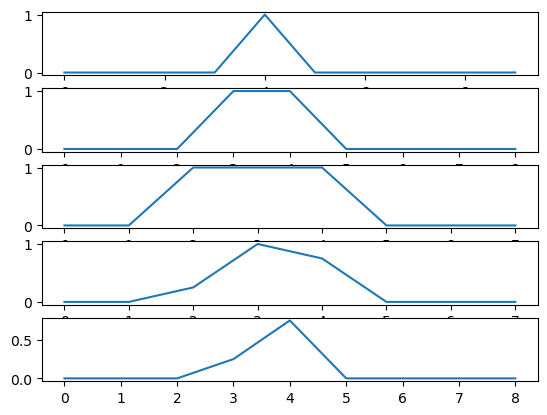

In [8]:

plot_all([
  dirac,
  convolve(dirac, np.array([1, 1])),
  convolve(dirac, np.array([1, 1, 1])),
  convolve(dirac, np.array([0.75, 1, 0.25])),
  convolve(dirac, np.array([0.75, 0.25])),
])

### Filters

array([0.2, 0.2, 0.2, 0.2, 0.2])

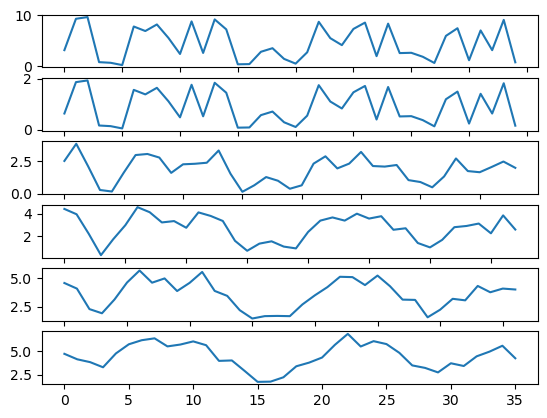

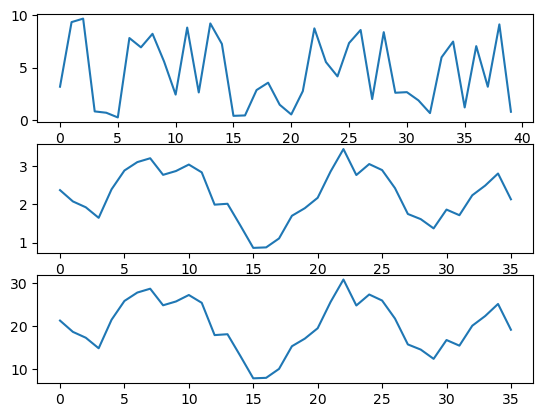

In [9]:
x = np.random.rand(40)*10.0

plot_all([
  x,
  convolve(x, np.full(1, 0.2)),
  convolve(x, np.full(2, 0.2)),
  convolve(x, np.full(3, 0.2)),
  convolve(x, np.full(4, 0.2)),
  convolve(x, np.full(5, 0.2)),
])
plot_all([
  x,
  convolve(x, np.full(5, 0.1)),
  convolve(x, np.full(5, 0.9)),
])
np.full(5, 0.2)

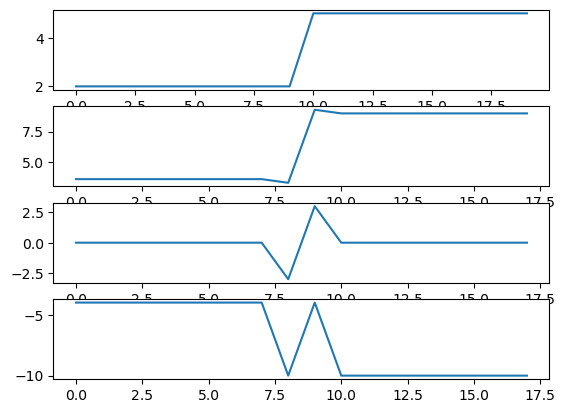

In [10]:
edge_detect_filter = np.array([-1,2,-1])

xe = np.concatenate((np.full(10, 2), np.full(10, 5)))
plot_all([
  xe,
  convolve(xe, np.array([-.1, 2, -.1])),
  convolve(xe, edge_detect_filter),
  convolve(xe, np.array([-2, 2, -2]))
])


## Pooling

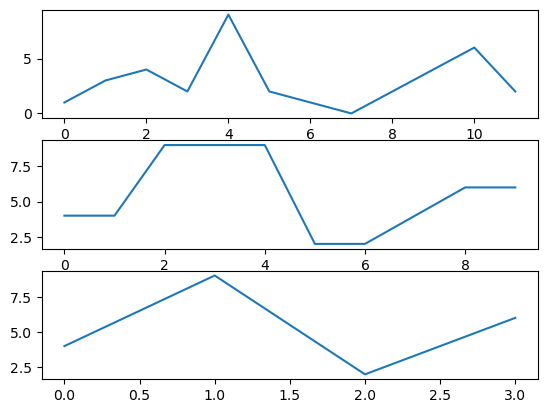

In [11]:
def pool_with_stride(x, f, n, stride):
  segments = [ x[i:(i+n)] for i in range(0, x.size-n+1, stride) ]
  return np.array([ f(u) for u in segments ])

x = np.array([1, 3, 4, 2, 9, 2, 1, 0, 2, 4, 6, 2])

plot_all([
  x,
  pool_with_stride(x, np.max, 3, 1),
  pool_with_stride(x, np.max, 3, 3)
])


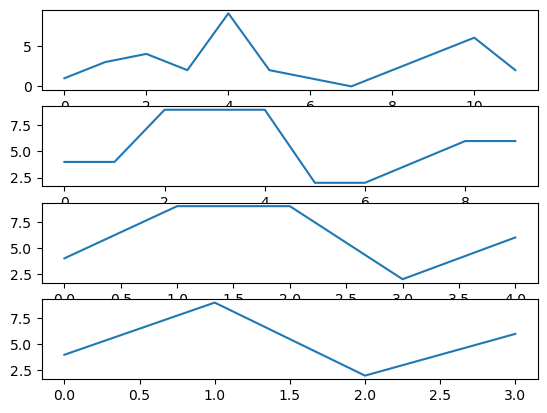

In [12]:

plot_all([
  x,
  pool_with_stride(x, np.max, 3, 1),
  pool_with_stride(x, np.max, 3, 2),
  pool_with_stride(x, np.max, 3, 3),
])

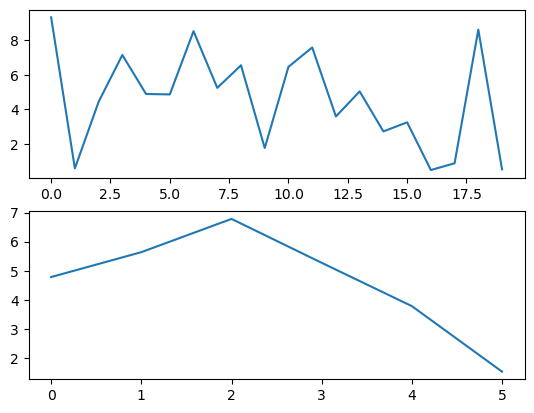

In [13]:
def pool_with_stride(x, f, n, stride):
  segments = [ x[i:(i+n)] for i in range(0, x.size-n+1, stride) ]
  return np.array([ f(u) for u in segments ])

x = np.random.rand(20)*10.0

plot_all([
  x, 
  pool_with_stride(x, np.mean, 3, 3)
])


## Combine

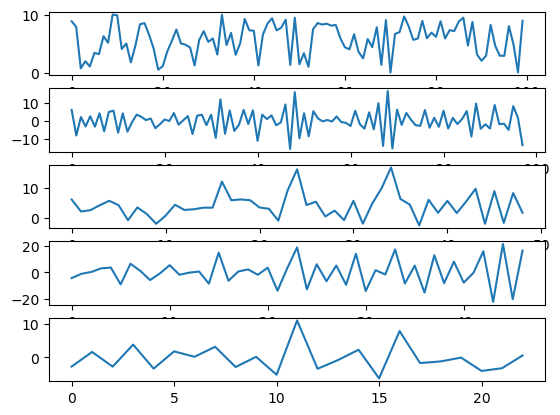

In [14]:
x = np.random.rand(100)*10.0
x1 = convolve(x, edge_detect_filter)      # filter size is 3
x2 = pool_with_stride(x1, np.max, 2, 2)   # pooling size is 2
x3 = convolve(x2, edge_detect_filter)
x4 = pool_with_stride(x3, np.average, 2, 2)
plot_all([
  x, 
  x1,
  x2,
  x3,
  x4
])


## 2D

In [15]:
x  = np.array([[3, 0, 1, 2, 3, 1, 1, 1],
               [1, 3, 4, 2, 9, 2, 1, 0]])
filter = np.array([[0.5, 1,   1],
                   [1,   0, 0.5]])

n = filter.shape[1]
y = []
for i in range(x.shape[1] - n + 1):
  product = x[:, i:(i+n)] * filter
  y.append(np.sum(product))

print(y)


[5.5, 7.0, 14.0, 8.0, 13.0, 4.5]


# Keras Examples

In [16]:
def get_cnn_model(num_filters=32):
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=(28,28,1)))
  model.add(keras.layers.Conv2D(num_filters, (3, 3), activation='relu'))
  model.add(keras.layers.MaxPooling2D((2, 2)))
  # model.add(keras.layers.Conv2D(num_filters, (3, 3), activation='relu'))
  # model.add(keras.layers.MaxPooling2D((2, 2)))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(4, activation='relu'))
  model.add(keras.layers.Dense(10, activation='softmax'))
  return model

def get_ff_model(num_neurons=32):
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=(28,28,1)))
  model.add(keras.layers.Reshape((28 * 28,), input_shape=(28, 28)))  # Reshape the input from (28, 28) to (28*28,)
  model.add(keras.layers.Dense(num_neurons, activation='relu'))
  # model.add(keras.layers.Dense(num_neurons, activation='relu'))
  model.add(keras.layers.Dense(10, activation='softmax'))  # Output layer for 10 classes
  return model

In [21]:

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (normalize to 0-1 and reshape)
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0


def train_model(model):
  
  # Compile the model
  model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
  
  # Train the model
  history = model.fit(
    x_train, 
    y_train, 
    epochs=40, 
    batch_size=256, 
    validation_data=(x_test, y_test)
  )
  
  # Evaluate the model
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  print(f'Test accuracy: {test_acc}')
  return history

Epoch 1/40
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2473 - loss: 2.0864 - val_accuracy: 0.5703 - val_loss: 1.3415
Epoch 2/40
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6245 - loss: 1.2160 - val_accuracy: 0.7257 - val_loss: 0.9441
Epoch 3/40
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7387 - loss: 0.8975 - val_accuracy: 0.7808 - val_loss: 0.7690
Epoch 4/40
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7812 - loss: 0.7587 - val_accuracy: 0.8019 - val_loss: 0.6867
Epoch 5/40
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8041 - loss: 0.6801 - val_accuracy: 0.8148 - val_loss: 0.6383
Epoch 6/40
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8159 - loss: 0.6374 - val_accuracy: 0.8278 - val_loss: 0.6041
Epoch 7/40
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8255 - loss: 0.6109 - val_accuracy: 0.8355 - val_loss: 0.5796
Epoch 8/40
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8298 - loss: 0.5876 - val_accuracy: 0

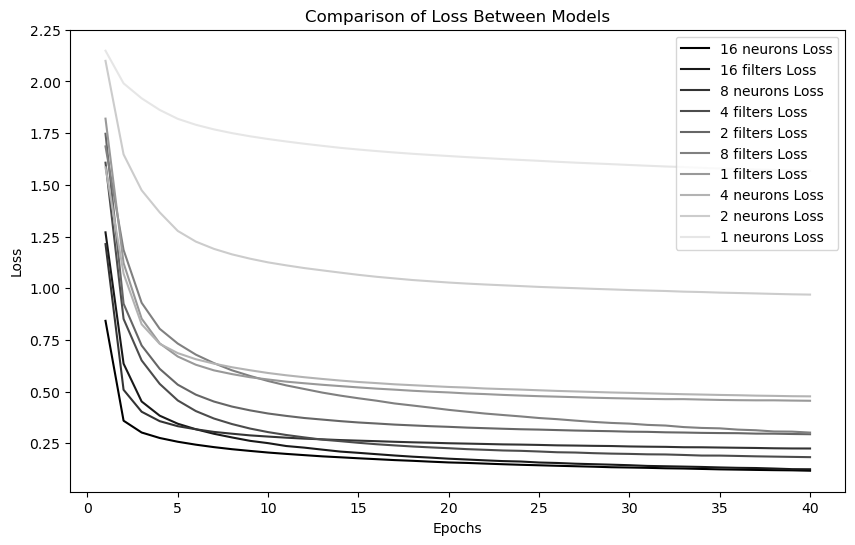

In [22]:
histories = {}
histories.update({
  f"{2**i} filters" : train_model(get_cnn_model(2**i))
  for i in range(0,5)
})
histories.update({
  f"{2**i} neurons" : train_model(get_ff_model(2**i))
  for i in range(0,5)
})


plot_multiple_histories(
  histories=histories,
  metric="loss"
)

In [19]:
models = {}
models.update({
  f"{2**i} filters" : get_cnn_model(2**i)
  for i in range(0,5)
})
models.update({
  f"{2**i} neurons" : get_ff_model(2**i)
  for i in range(0,5)
})

In [20]:
for name, model in models.items():
  print(f"{name} : {model.count_params()}")

1 filters : 740
2 filters : 1426
4 filters : 2798
8 filters : 5542
16 filters : 11030
1 neurons : 805
2 neurons : 1600
4 neurons : 3190
8 neurons : 6370
16 neurons : 12730
